In [1]:
import json 
import pandas as pd 
import numpy as np 
import os 
import seaborn as sns 
import matplotlib.pyplot as plt 
from glob import glob 
os.chdir('../')

def load_df(log_dir):
    with open(log_dir, 'r') as f: 
        data = f.readlines()
    df = pd.DataFrame(list(pd.Series(data).map(eval).values))    
    return df 

def load_log_data(class_name, version, result_dir,method):

    df = pd.DataFrame()
    for i,v in enumerate(version):
        log_dir = os.path.join(result_dir,class_name,method,v,'log.txt')
        
        temp_df = load_df(log_dir)
        temp_df['hue'] = v 
        
        df = pd.concat([df,temp_df])
    
    return df 

def plot_log(data,class_name, metrics:list, figsize:tuple = (10,7)):
    
    fig, axes = plt.subplots(len(metrics),1,figsize=figsize)
    
    for ax, metric in zip(axes, metrics):
        sns.lineplot(
            x = 'epoch',
            y = metric,
            data = data,
            hue = data['hue'],
            ax = ax 
        )
      
    fig.suptitle(class_name)
    plt.show()
    
def read_txt(log_dir):
    with open(log_dir, 'r') as f: 
        data = f.readlines()    
    df = pd.DataFrame([eval(d) for d in data]) 
    return df 
pd.options.display.float_format = '{: .3f}'.format 

In [19]:
import numpy as np 


2.718281828459045

In [25]:
from scipy.special import lambertw
W = lambertw
tau = 0.5 
noise = 0.7 
clean = 0.2 
Lambda = 1 
noise_sigma = np.exp(-W((noise - tau)/(2*Lambda)))
clean_sigma = np.exp(-W((clean - tau)/(2*Lambda)))

In [27]:
noise_sigma, clean_sigma

((0.9127652716086226-0j), (1.1966084556532315-0j))

# 전체 결과 

In [2]:
version = ['*-anomaly_ratio_0.0']

result_dir = './results'
dataset = ''
method = '*'
log_dirs = glob('/Volume/ProxyCore/results/*/*/*/*-anomaly_ratio_0.0/seed_0/result.txt')
#log_dirs = pd.Series(log_dirs)[pd.Series(log_dirs).apply(lambda x  : x.split('/')[-3].split('-')[0] == 'baseline')].values
df = pd.DataFrame()

for log_dir in log_dirs:
    auroc_list = {}
    method = log_dir.split('/')[-6]
    dataset = log_dir.split('/')[-5]
    class_name = log_dir.split('/')[-4]
    exp_name = log_dir.split('/')[-3].split('-')[0]
    
    data = load_df(log_dir)

    met = [d['pix_level']['average_precision'] for d in data['test_metrics']]    
    # if method in ['ReconPatch','ProxyCoreBase','CoreInit']:
    #     met[0] = 0
        
    idx = np.argmax(met)
    
    result = pd.DataFrame(data['test_metrics'][idx])
    result = result.reset_index().melt(['index'])
    result.columns = ['metric','level','value']
    
    if exp_name == 'baseline_yen':
        method = 'softpatch-yen'
    anomaly_ratio = float(log_dir.split('/')[-3].split('_')[-1])
    
    for c in ['method','dataset','class_name','exp_name','anomaly_ratio']:
        result[c] = eval(c) 
    
    
    
    df = pd.concat([df,result])

df = df[df['metric'].apply(lambda x : x in ['auroc','loco_auroc','average_precision'])].reset_index(drop=True)
df.loc[df['metric']=='loco_auroc','structural_anomalies'] = df[df['metric']=='loco_auroc']['value'].apply(lambda x : x['structural_anomalies'])
df.loc[df['metric']=='loco_auroc','logical_anomalies'] = df[df['metric']=='loco_auroc']['value'].apply(lambda x : x['logical_anomalies'])

# df = df.melt(['index','class','anomaly_ratio','exp_name'])
# # exp_d = {'Proxy_single_base' : 'ProxyNCA', 'Proxy_single_anchor_loss':'Proxy anchor', 'Proxy_nsoftmax' : 'Proxy nSoftmax'}
# # df['exp_name'] = df['exp_name'].map(exp_d)
# ind_d = {'img_level':'Image Level', 'pix_level' : 'Pixel Level'}
# df['index'] = df['index'].map(ind_d)

exp = df[
    (df['exp_name'].apply(lambda x : 'BASELINE' in x ))&
    (df['exp_name'].apply(lambda x : x not in ['BASELINE_CosineAnnealingLR', 'BASELINE_LR', 'BASELINE_Temperature_more', 'BASELINE_Temperature'] ))&
    (df['method']=='CoreInit')
    ].reset_index(drop=True).pivot_table(index=['class_name','level','dataset','metric'],columns=['exp_name'],values='value',aggfunc='max')

exp = exp.reset_index().melt(id_vars=['class_name','level','dataset','metric'])
exp['FocalLoss']    = exp['exp_name'].apply(lambda x : 'focalloss' if 'focalloss' in x else 'CrossEntropy')
exp['Augmentation'] = exp['exp_name'].apply(lambda x : 'None' if 'no_augment' in x else 'Augment')
exp['Label_core']   = exp['exp_name'].apply(lambda x : 'norm_core' if 'norm_core' in x else 'Core')
exp['Temperature']  = exp['exp_name'].apply(lambda x : x.split('_')[-1]).apply(lambda x : 0.05 if x =='BASELINE' else x).apply(lambda x : 0.05 if x == 'focalloss' else x).apply(lambda x : x[-1] if x in ['T1','T2'] else x ).map(float)
exp['Proxy_init']   = exp['exp_name'].apply(lambda x : 'rand_init' if 'rand_init' in x else 'coreset_init')

exp['method'] = 'CoreInit'

In [15]:
exp[
    (exp['dataset']=='VISA')&
    (exp['metric']=='average_precision') &
    (exp['FocalLoss']=='focalloss') &
    (exp['level']=='pix_level')
    ].pivot_table(index=['class_name'],columns=['Temperature'],values='value')

Temperature,0.100,0.500,1.000,2.000
class_name,,,,
capsules,NaN,0.727,NaN,NaN
cashew,0.602,0.574,0.571,0.563


In [18]:
exp1= exp[
     (exp['dataset']=='MPDD') &
     (exp['Label_core']=='norm_core') & # norm_core, Core 
     (exp['FocalLoss']=='focalloss') & #CrossEntropy, focalloss 
     (exp['Proxy_init']=='coreset_init') & #rand_init coreset_init
     (exp['Augmentation']=='Augment') &
    #  (exp['Temperature']==0.1) &
     (exp['metric']=='average_precision') &
     (exp['level']=='pix_level')
     ].pivot_table(index=['level','class_name'],columns=['Temperature'],values='value',aggfunc='mean')

base = df[
    (df['exp_name'].apply(lambda x : 'BASELINE' in x ))&
    (df['metric'].apply(lambda x : 'loco' not in x ))&
    (df['method'] != 'CoreInit')
    ].reset_index(drop=True).pivot_table(index=['class_name','level','dataset','metric','method'],columns=['exp_name'],values='value',aggfunc='max')
base = base.reset_index().melt(id_vars=['class_name','level','dataset','metric','method'])

base1= base[
    (base['dataset']=='BTAD') &
    (base['metric']=='average_precision') 
    # (base['level']=='pix_level')
].pivot_table(index=['level','class_name'],columns=['method'],values='value')

In [19]:
exp1

Temperature              0.100
level     class_name          
pix_level bracket_black  0.207
          bracket_brown  0.253
          bracket_white  0.255
          connector      0.709
          metal_plate    0.941
          tubes          0.690

In [4]:
result = pd.concat([base1,exp1],axis=1)
#result.index = base1.reset_index()['class_name'].apply(lambda x : x.title()).values
#result.loc['Average'] = result.mean()

In [ ]:
img_level = result.loc['img_level']
img_level.loc['Average'] = img_level.mean()

pix_level = result.loc['pix_level']
pix_level.loc['Average'] = pix_level.mean()

In [7]:
img_level

method,FastFlow,PatchCore,ReverseDistillation,CoreInit
class_name,,,,
1,1.000,0.993,0.998,0.993
2,0.981,0.974,0.978,0.977
3,0.926,0.997,0.997,0.996
Average,0.969,0.988,0.991,0.989


In [209]:
exp1 = exp[
     (exp['dataset']=='VISA') &
     (exp['Label_core']=='Core') & # norm_core, Core 
     (exp['FocalLoss']=='CrossEntropy') & #CrossEntropy, focalloss 
     (exp['Proxy_init']=='coreset_init') & #rand_init coreset_init
     (exp['Augmentation']=='Augment') &
     # (exp['Temperature']==0.5) &
     (exp['metric']=='average_precision') &
     (exp['level']=='pix_level')
     ].pivot_table(index=['class_name'],columns=['Temperature'],values='value')
exp1.loc['Average'] = exp1.mean()

In [210]:
exp1

Temperature,0.050,0.100,0.500,1.000,2.000
class_name,,,,,
candle,0.316,NaN,0.308,0.308,0.308
capsules,0.724,0.720,0.727,NaN,NaN
cashew,0.605,0.602,0.574,0.570,0.564
chewinggum,0.676,0.675,0.623,0.605,0.610
fryum,0.389,0.388,0.388,0.389,0.387
macaroni1,0.274,NaN,NaN,NaN,NaN
macaroni2,NaN,0.167,0.151,0.144,0.145
pcb1,NaN,0.861,NaN,0.846,0.838
pcb2,NaN,0.206,0.230,NaN,NaN


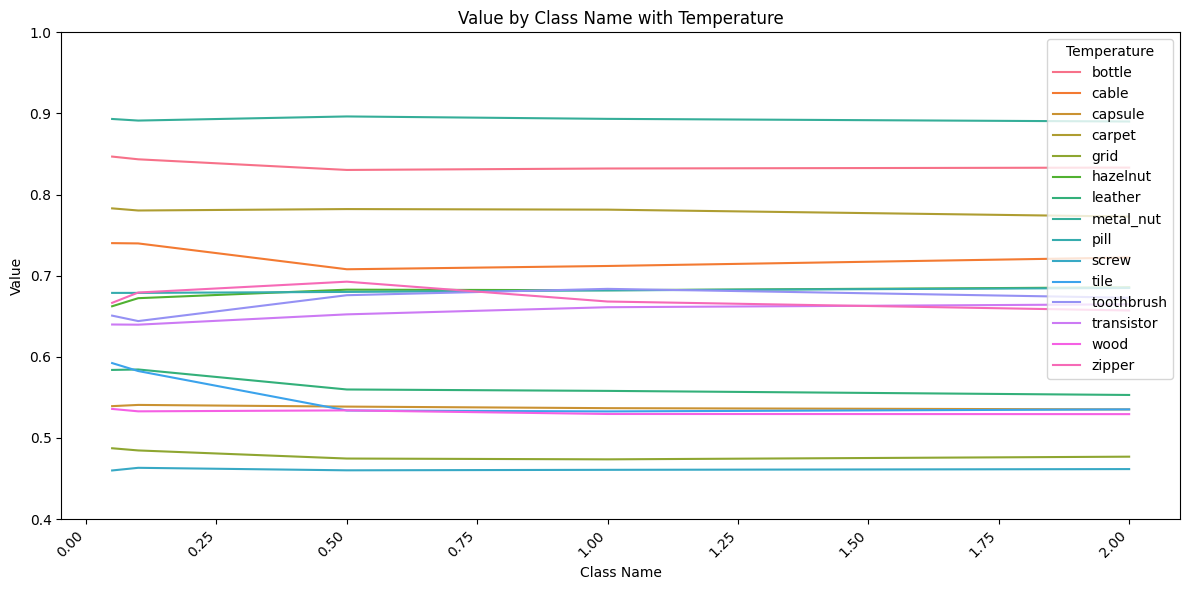

In [127]:


# 그래프 그리기
plt.figure(figsize=(12, 6))
sns.lineplot(data=exp1, x='Temperature', y='value', hue='class_name')

# x 축 범례 기울이기
plt.xticks(rotation=45, ha='right')

# 색상 변경
sns.set_palette("pastel")

plt.title('Value by Class Name with Temperature')
plt.xlabel('Class Name')
plt.ylabel('Value')
plt.legend(title='Temperature')
plt.ylim(0.4,1.0)
#plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [64]:
exp1.T.mean()

dataset
MVTecAD    0.651
dtype: object